# Bee Colony Capstone - modeling step, using 3 regression models

## Import modules

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn import model_selection
from sklearn import pipeline
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics
from patsy import dmatrices
from patsy import dmatrix

## Import data

In [186]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

y_train = y_train['LogFinalToStart'].ravel()
y_test = y_test['LogFinalToStart'].ravel()

# This will only be used for the statsmodel formula, prior to indexing removing the unmodified columns
bee_colony_data = pd.read_csv('bees_post_eda.csv')

## Design matrices specification

In [187]:
# naive predictors
X_train_null = np.ones(shape=y_train.shape[0]).reshape(-1, 1)

# Rename the varroa mites column to make it easier to work with
X_train.rename(columns = {'Varroa mites': 'varroa_mites'}, inplace=True)
X_test.rename(columns = {'Varroa mites': 'varroa_mites'}, inplace=True)

# Regions only
X_train_regions = X_train[['region_midwest', 'region_northeast', 'region_south', 'region_west']]
X_test_regions = X_test[['region_midwest', 'region_northeast', 'region_south', 'region_west']]

# Subregions only - breaking the larger regions down further
subregion_cols = [col for col in X_train.columns.values.tolist() if col.startswith("subregion_")]
X_train_subregions = X_train[subregion_cols]
X_test_subregions = X_test[subregion_cols]

# All pest and other causes of colony loss columns
X_train_all_pests = X_train[['varroa_mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']]
X_test_all_pests = X_test[['varroa_mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']]

# Varroa mites column plus subregion columns
# I tried to use the subregion_cols variable here, but I couldn't figure out how to make it work with the mite column
X_train_mites_subregions = X_train[['varroa_mites', 'subregion_east north central', 'subregion_east south central',
       'subregion_mid atlantic', 'subregion_mountain', 'subregion_new england',
       'subregion_pacific', 'subregion_south atlantic',
       'subregion_west north central', 'subregion_west south central']]
X_test_mites_subregions = X_test[['varroa_mites', 'subregion_east north central', 'subregion_east south central',
       'subregion_mid atlantic', 'subregion_mountain', 'subregion_new england',
       'subregion_pacific', 'subregion_south atlantic',
       'subregion_west north central', 'subregion_west south central']]

# Varroa mites data with larger regions
X_train_mites_regions = X_train[['varroa_mites', 'region_midwest', 'region_northeast', 'region_south', 'region_west']]
X_test_mites_regions = X_test[['varroa_mites', 'region_midwest', 'region_northeast', 'region_south', 'region_west']]

# Patsy matrices

# Using a negative one to exclude the intercept
patsy = "(region_west + region_midwest + region_northeast + region_south) * (varroa_mites + Pesticides) - 1"
# When I did the encoding or the indexing in the preprocessing step, it stripped out the 
# plain region / state / subregion columns and replaced them with the dummy columns
# So, I went ahead and added the regions together and multiplied them by the varroa mites and pesticides

train_model_matrix = dmatrix(patsy, X_train)
train_model_matrix_names = train_model_matrix.design_info.column_names

test_model_matrix = dmatrix(patsy, X_test)
test_model_matrix_names = test_model_matrix.design_info.column_names
print(test_model_matrix_names)

['region_west', 'region_midwest', 'region_northeast', 'region_south', 'varroa_mites', 'Pesticides', 'region_west:varroa_mites', 'region_west:Pesticides', 'region_midwest:varroa_mites', 'region_midwest:Pesticides', 'region_northeast:varroa_mites', 'region_northeast:Pesticides', 'region_south:varroa_mites', 'region_south:Pesticides']


## Feature coefficients with statsmodels

In [188]:
bee_colony_data.rename(columns = {'Varroa mites': 'varroa_mites', 'Percent lost': 'percent_lost'}, inplace=True)

mod = smf.ols(formula='percent_lost ~ region + subregion + State + year + quarter + varroa_mites + Pesticides + Diseases', data=bee_colony_data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           percent_lost   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     8.602
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           2.33e-46
Time:                        20:10:00   Log-Likelihood:                -2807.2
No. Observations:                 878   AIC:                             5712.
Df Residuals:                     829   BIC:                             5946.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         411.1521    222.179      1.851      0.065     -24.948     847.253
region[T.northeast]                28.0471     16.668      1.683      0.093      -4.670      60.764
region[T.south]                    39.3727     20.716      1.901      0.058      -1.289      80.035
region[T.west]                     30.9362     17.706      1.747      0.081      -3.817      65.689
subregion[T.east south central]    19.1043      7.839      2.437      0.015       3.717      34.492
subregion[T.mid atlantic]          16.0905      8.840      1.820      0.069      -1.260      33.441
subregion[T.mountain]              17.3550      9.158      1.895      0.058      -0.621      35.331
subregion[T.new england]           11.9566      7.866      1.520      0.129      -3.484      27.397
subregion[T.pacific]               13.5813      8.570      1.585      0.113      -3.240      30.402
subregion[T.south atlantic]        11.1078      6.772      1.640      0.101      -2.184      24.399
subregion[T.west north central]    44.5699     24.880      1.791      0.074      -4.266      93.406
subregion[T.west south central]     9.1605      6.214      1.474      0.141      -3.037      21.358
State[T.Arizona]                -3.015e-12   1.63e-12     -1.852      0.064   -6.21e-12    1.81e-13
State[T.Arkansas]                   6.5936      1.962      3.361      0.001       2.743      10.444
State[T.California]                 5.6711      2.482      2.285      0.023       0.800      10.542
State[T.Colorado]                   3.8372      1.988      1.930      0.054      -0.065       7.739
State[T.Connecticut]                5.5656      4.114      1.353      0.176      -2.510      13.641
State[T.Florida]                    2.5011      1.471      1.700      0.089      -0.386       5.388
State[T.Georgia]                    1.7505      1.478      1.185      0.236      -1.150       4.651
State[T.Hawaii]                     1.8648      3.011      0.619      0.536      -4.046       7.776
State[T.Idaho]                      1.9886      1.937      1.027      0.305      -1.814       5.791
State[T.Illinois]                  55.4491     28.476      1.947      0.052      -0.444     111.343
State[T.Indiana]                   53.5351     28.474      1.880      0.060      -2.355     109.425
State[T.Iowa]                       6.2215      3.717      1.674      0.095      -1.075      13.518
State[T.Kansas]                    11.7450      3.763      3.121      0.002       4.360      19.130
State[T.Kentucky]                  -3.2913      1.889     -1.742      0.082      -6.999       0.416
State[T.Louisiana]                 -1.3499      1.977     -0.683      0.495      -5.230       2.530
State[T.Maine]                   2.383e-15    8.4e-16      2.835      0.005    7.33

## Set up cross-validator

In [189]:
cross_validator = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

## Linear ridge regression

#### LRR  - create model object

In [190]:
lr_baseline = linear_model.Ridge(fit_intercept=False, max_iter=500, random_state=42)

#### LRR - create params object

In [191]:
lr_params = {"model__alpha": np.logspace(start=-10, stop=2, num=40)}

#### LRR - create pipeline

In [192]:
lr_pipeline = pipeline.Pipeline(steps=[("model", lr_baseline)])

#### LRR - create baseline grid

In [193]:
lr_baseline_grid = model_selection.GridSearchCV(
                        estimator=lr_pipeline,
                        param_grid=lr_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Linear Ridge regression - naive model

#### LRR: naive - fit model

In [194]:
start = time.time()
lr_base_mod = lr_baseline_grid.fit(X_train_null, y_train)
end = time.time()

print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.30 seconds


#### LRR: naive - CV score distribution

Elapsed time: 0.01 seconds


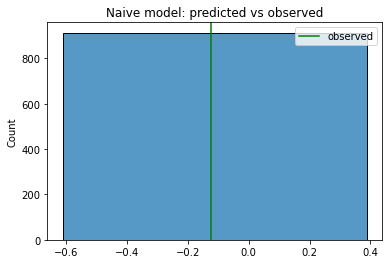

In [195]:
lr_base_best_estimator = lr_base_mod.best_estimator_

# Distribution of cross-validator score
start = time.time()
lr_cv_scores = model_selection.cross_val_score(
                    lr_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

# Predict y on training data
y_pred_train_naive = lr_base_best_estimator.predict(X_train_null)
sns.histplot(y_pred_train_naive).set(title='Naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: naive - train / test comparison

In [196]:
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1, 1)

# Predict y on test data
y_pred_test_naive = lr_base_best_estimator.predict(X_test_null)

#### LRR: naive - calculate metrics

In [197]:
print(f"Mean train CV score: {np.mean(lr_cv_scores): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=y_pred_test_naive): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=y_pred_test_naive): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test_naive, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.050
Test R-squared: -0.020
Test RMSE:  0.084


### Linear Ridge regression - with feature data

#### LRR: with features - fit model - predictor: regions

In [198]:
start = time.time()
lr_regions_mod = lr_baseline_grid.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.62 seconds


#### LRR: with features - CV score distribution - predictor: regions

Elapsed time: 0.02 seconds


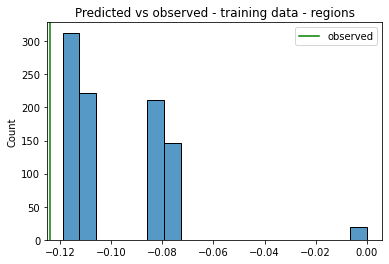

In [199]:
lr_regions_best_estimator = lr_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_regions = model_selection.cross_val_score(
                    lr_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

# Predict y on training data
y_train_lr_pred_regions = lr_regions_best_estimator.predict(X_train_regions)
sns.histplot(y_train_lr_pred_regions).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: regions

In [200]:
y_test_lr_pred_regions = lr_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=y_test_lr_pred_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=y_test_lr_pred_regions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=y_test_lr_pred_regions, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.046
Test R-squared: -0.152
Test RMSE:  0.089


#### LRR: with features - plotting observed vs predicted - predictor: regions

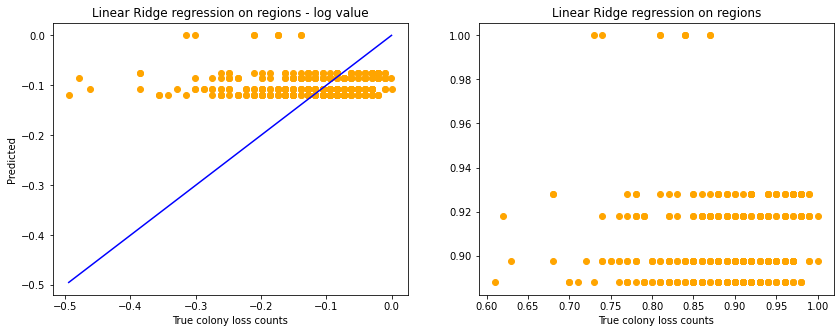

In [201]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_test_lr_pred_regions, c="orange")

p1 = max(max(y_test_lr_pred_regions), max(y_test))
p2 = min(min(y_test_lr_pred_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts', ylabel='Predicted', title="Linear Ridge regression on regions - log value")

ax2.scatter(np.exp(y_test), np.exp(y_test_lr_pred_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge regression on regions")

plt.show()

#### LRR: with features - fit model - predictor: subregions

In [202]:
start = time.time()
lr_subregions = lr_baseline_grid.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.63 seconds


#### LRR: with features - CV score distribution - predictor: subregions

Elapsed time: 0.02 seconds


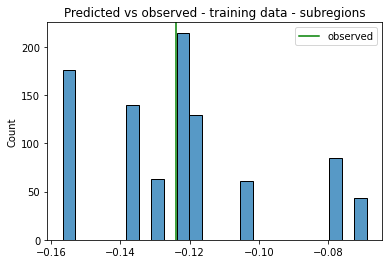

In [203]:
lr_subregions_best_estimator = lr_subregions.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_subregions = model_selection.cross_val_score(
                    lr_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_subregions = lr_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(lr_train_pred_subregions).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: subregions

In [204]:
lr_subregions_test_pred = lr_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_subregions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_subregions_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_subregions_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_subregions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.050
Test R-squared:  0.079
Test RMSE:  0.080


#### LRR: with features - plotting observed vs predicted - predictor: subregions

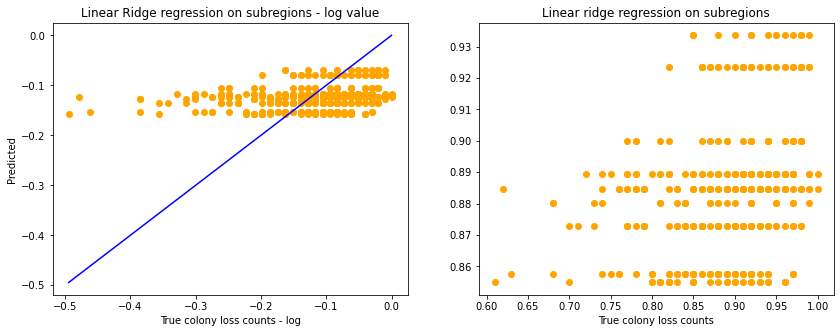

In [205]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, lr_subregions_test_pred, c="orange")

p1 = max(max(lr_subregions_test_pred), max(y_test))
p2 = min(min(lr_subregions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on subregions - log value")

ax2.scatter(np.exp(y_test), np.exp(lr_subregions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Linear ridge regression on subregions')

plt.show()

#### LRR: with features - fit model - predictor: pests

In [206]:
start = time.time()
lr_all_pests_mod = lr_baseline_grid.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.62 seconds


#### LRR: with features - CV score distribution - predictor: pests

Elapsed time: 0.02 seconds


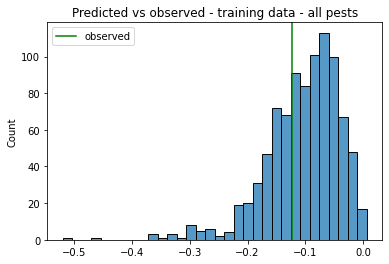

In [207]:
lr_all_pests_best_estimator = lr_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_all_pests = model_selection.cross_val_score(
                    lr_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

# Plot CV scores
lr_train_pred_all_pests = lr_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(lr_train_pred_all_pests).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: pests

In [208]:
lr_all_pests_test_pred = lr_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(lr_cv_scores_all_pests): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_all_pests_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_all_pests_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_all_pests_test_pred, squared=False): .3f}")

Mean train CV score: -0.064
Test MAE:  0.046
Test R-squared: -0.302
Test RMSE:  0.095


#### LRR: with features - plotting observed vs predicted - predictor: pests

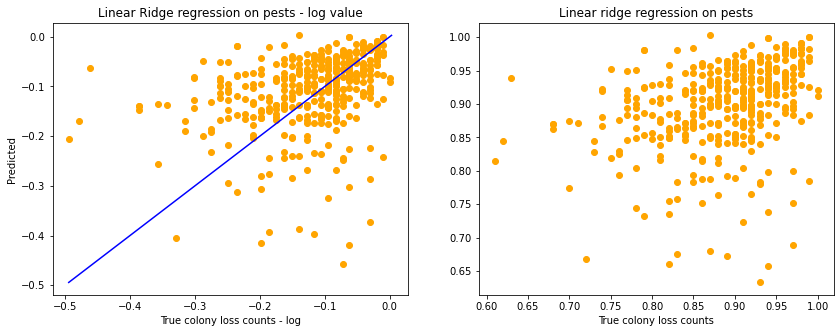

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, lr_all_pests_test_pred, c="orange")

p1 = max(max(lr_all_pests_test_pred), max(y_test))
p2 = min(min(lr_all_pests_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on pests - log value")

ax2.scatter(np.exp(y_test), np.exp(lr_all_pests_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Linear ridge regression on pests')

plt.show()

#### LRR: with features - fit model - predictor: varroa mites and regions

In [210]:
start = time.time()
lr_mites_regions = lr_baseline_grid.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.73 seconds


#### LRR: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.02 seconds


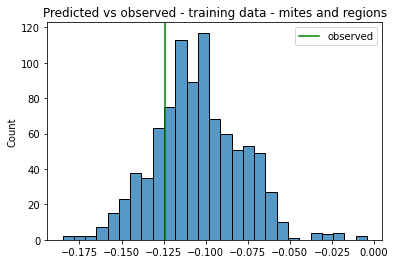

In [211]:
lr_mites_regions_best_estimator = lr_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_mites_regions = model_selection.cross_val_score(
                    lr_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_mites_regions = lr_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(lr_train_pred_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: mites and regions

In [212]:
lr_test_pred_mites_regions = lr_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(lr_cv_scores_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_test_pred_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_test_pred_mites_regions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_test_pred_mites_regions, squared=False): .3f}")

Mean train CV score: -0.063
Test MAE:  0.047
Test R-squared: -0.097
Test RMSE:  0.087


#### LRR: with features - plotting observed vs predicted - predictor: mites and regions

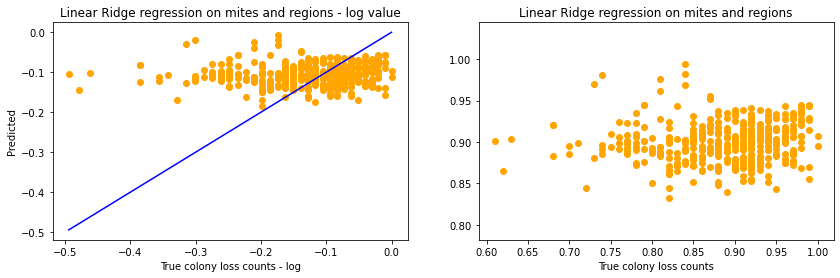

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, lr_test_pred_mites_regions, c="orange")

p1 = max(max(lr_test_pred_mites_regions), max(y_test))
p2 = min(min(lr_test_pred_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge regression on mites and regions - log value")

ax2.scatter(np.exp(y_test), np.exp(lr_test_pred_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge regression on mites and regions")
ax2.axis('equal')

plt.show()

#### LRR: with features - fit model - predictor: Patsy matrix of mites, pesticides, and regions

In [214]:
start = time.time()
lr_matrix_mod = lr_baseline_grid.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Elapsed time: 0.32 seconds


#### LRR: with features - CV score distribution - predictor: Patsy matrix of mites, pesticides, and regions

Elapsed time: 0.01 seconds


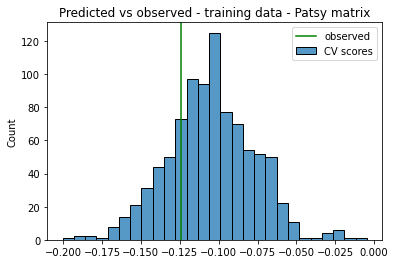

In [215]:
lr_matrix_best_estimator = lr_matrix_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
lr_cv_scores_matrix = model_selection.cross_val_score(
                    lr_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

lr_train_pred_matrix = lr_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(lr_train_pred_matrix, label='CV scores').set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### LRR: with features - metrics - predictor: Patsy matrix of mites, pesticides, and regions

In [216]:
lr_test_pred_matrix = lr_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(lr_cv_scores_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=lr_test_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=lr_test_pred_matrix): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=lr_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.064
Test MAE:  0.046
Test R-squared: -0.104
Test RMSE:  0.087


#### LRR: with features - plotting observed vs predicted - predictor: Patsy matrix of mites, pesticides, and regions

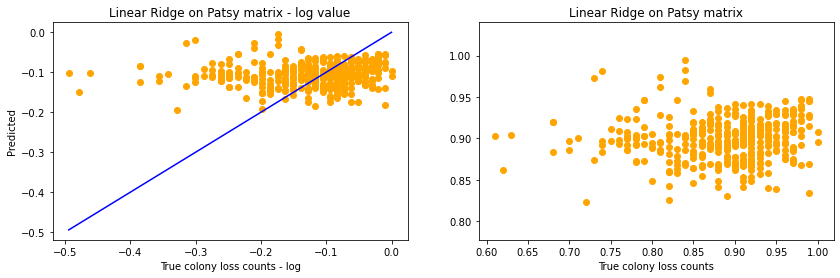

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, lr_test_pred_matrix, c="orange")

p1 = max(max(lr_test_pred_matrix), max(y_test))
p2 = min(min(lr_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Linear Ridge on Patsy matrix - log value")

ax2.scatter(np.exp(y_test), np.exp(lr_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Linear Ridge on Patsy matrix")
ax2.axis('equal')

plt.show()

## Random Forest regression

#### RF - create model object

In [218]:
rf_base_model = ensemble.RandomForestRegressor(random_state=42, bootstrap = True)

#### RF - create params object

In [219]:
rf_params = {'model__n_estimators': [50,100,150], 
             'model__max_depth': [None,4,8], 
             'model__min_samples_split': np.arange(2,20,5),
             'model__max_features': [0.3,0.5,1,'sqrt','auto'],
             'model__max_samples': [20]}

#### RF - create pipeline

In [220]:
rf_pipeline = pipeline.Pipeline(steps=[("model", rf_base_model)])

#### RF - create baseline grid

In [221]:
rf_baseline_grid = model_selection.GridSearchCV(
                        estimator=rf_pipeline,
                        param_grid=rf_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Random Forest - naive model

#### RF: naive - fit model

In [222]:
start = time.time()
rf_base_mod = rf_baseline_grid.fit(X_train_null, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 79.13 seconds


#### RF: naive - CV score distribution

Elapsed time: 0.68 seconds


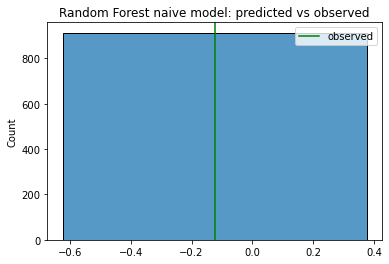

In [223]:
rf_base_best_estimator = rf_base_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores = model_selection.cross_val_score(
                    rf_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_train_pred_naive = rf_base_best_estimator.predict(X_train_null)
sns.histplot(rf_train_pred_naive).set(title='Random Forest naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()
plt.show()

#### RF: naive - train / test comparison

In [224]:
rf_test_pred_naive = rf_base_best_estimator.predict(X_test_null)

print(f"Mean train CV score: {np.mean(rf_cv_scores): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_test_pred_naive): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_test_pred_naive): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_test_pred_naive, squared=False): .3f}")

Mean train CV score: -0.068
Test MAE:  0.051
Test R-squared: -0.000
Test RMSE:  0.083


### Random Forest: with features

#### RF: with features - fit model - predictor: regions

In [225]:
start = time.time()
rf_regions_mod = rf_baseline_grid.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 77.83 seconds


#### RF: with features - CV score distribution - predictor: regions

Elapsed time: 0.71 seconds


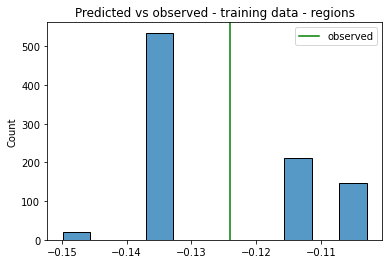

In [226]:
rf_regions_best_estimator = rf_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_regions = model_selection.cross_val_score(
                    rf_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_regions_train_pred = rf_regions_best_estimator.predict(X_train_regions)
sns.histplot(rf_regions_train_pred).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: regions

In [227]:
rf_regions_test_pred = rf_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_regions_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_regions_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_regions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.053
Test R-squared:  0.028
Test RMSE:  0.082


#### RF: with features - plotting observed vs predicted - predictor: regions

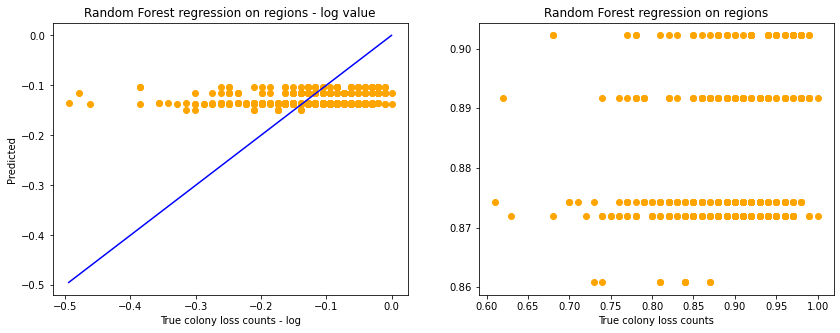

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_regions_test_pred, c="orange")

p1 = max(max(rf_regions_test_pred), max(y_test))
p2 = min(min(rf_regions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on regions - log value")

ax2.scatter(np.exp(y_test), np.exp(rf_regions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest regression on regions')

plt.show()

#### RF: with features - fit model - predictor: subregions

In [229]:
start = time.time()
rf_subregions_mod = rf_baseline_grid.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 76.78 seconds


#### RF: with features - CV score distribution - predictor: subregions

Elapsed time: 0.49 seconds


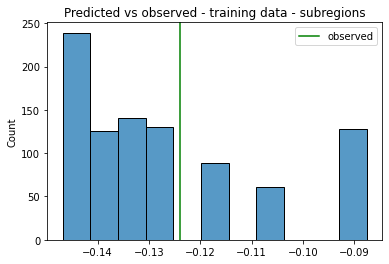

In [230]:
rf_subregions_best_estimator = rf_subregions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_subregions = model_selection.cross_val_score(
                    rf_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_subregions_train_pred = rf_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(rf_subregions_train_pred).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: subregions

In [231]:
rf_subregions_test_pred = rf_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_subregions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_subregions_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_subregions_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_subregions_test_pred, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.055
Test R-squared:  0.074
Test RMSE:  0.080


#### RF: with features - plotting observed vs predicted - predictor: subregions

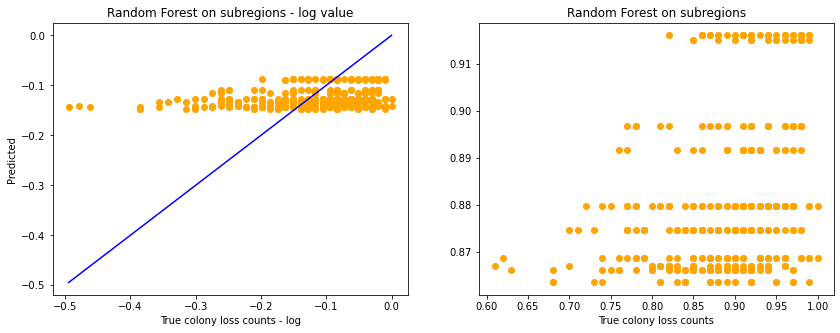

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_subregions_test_pred, c="orange")

p1 = max(max(rf_subregions_test_pred), max(y_test))
p2 = min(min(rf_subregions_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest on subregions - log value")

ax2.scatter(np.exp(y_test), np.exp(rf_subregions_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest on subregions')

plt.show()

#### RF: with features - fit model - predictor: pests

In [233]:
start = time.time()
rf_all_pests_mod = rf_baseline_grid.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 94.26 seconds


#### RF: with features - CV score distribution - predictor: pests

Elapsed time: 0.69 seconds


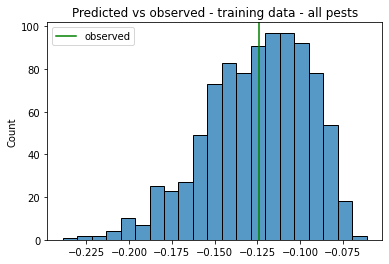

In [234]:
rf_all_pests_best_estimator = rf_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_all_pests = model_selection.cross_val_score(
                    rf_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_all_pests_train_pred = rf_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(rf_all_pests_train_pred).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: pests

In [235]:
rf_all_pests_test_pred = rf_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(rf_cv_scores_all_pests): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_all_pests_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_all_pests_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_all_pests_test_pred, squared=False): .3f}")

Mean train CV score: -0.063
Test MAE:  0.047
Test R-squared:  0.132
Test RMSE:  0.077


#### RF: with features - plotting observed vs predicted - predictor: pests

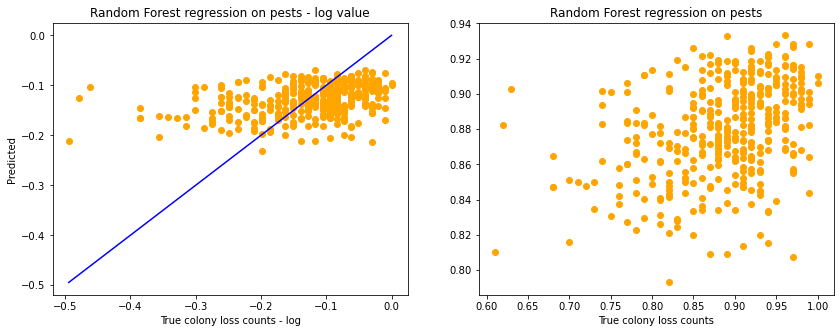

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, rf_all_pests_test_pred, c="orange")

p1 = max(max(rf_all_pests_test_pred), max(y_test))
p2 = min(min(rf_all_pests_test_pred), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on pests - log value")

ax2.scatter(np.exp(y_test), np.exp(rf_all_pests_test_pred), c="orange")
ax2.set(xlabel='True colony loss counts', title='Random Forest regression on pests')

plt.show()

#### RF: with features - fit model - predictor: mites and regions

In [237]:
start = time.time()
rf_mites_regions = rf_baseline_grid.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 79.45 seconds


#### RF: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.56 seconds


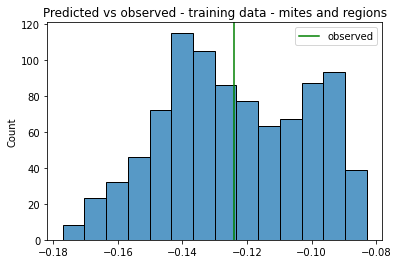

In [238]:
rf_mites_regions_best_estimator = rf_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_mites_regions = model_selection.cross_val_score(
                    rf_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_rf_mites_regions = rf_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(train_pred_rf_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: mites and regions

In [239]:
test_pred_rf_mites_regions = rf_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(rf_cv_scores_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_rf_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_rf_mites_regions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_rf_mites_regions, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.051
Test R-squared:  0.013
Test RMSE:  0.083


#### RF: with features - plotting observed vs predicted - predictor: mites and regions

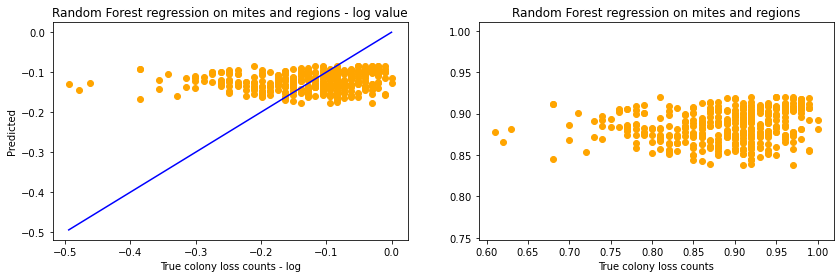

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, test_pred_rf_mites_regions, c="orange")

p1 = max(max(test_pred_rf_mites_regions), max(y_test))
p2 = min(min(test_pred_rf_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest regression on mites and regions - log value")

ax2.scatter(np.exp(y_test), np.exp(test_pred_rf_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Random Forest regression on mites and regions")
ax2.axis('equal')

plt.show()

#### RF: with features - fit model - predictor: Patsy matrix

In [241]:
start = time.time()
rf_matrix_train = rf_baseline_grid.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed time: 79.15 seconds


#### RF: with features - CV score distribution - predictor: Patsy matrix

Elapsed time: 0.73 seconds


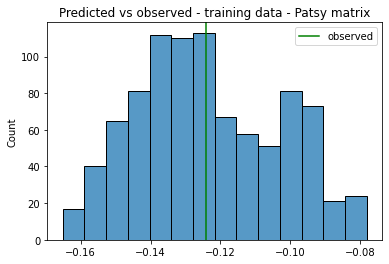

In [242]:
rf_matrix_best_estimator = rf_matrix_train.best_estimator_

# Distribution of cross-val score
start = time.time()
rf_cv_scores_matrix = model_selection.cross_val_score(
                    rf_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

rf_train_pred_matrix = rf_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(rf_train_pred_matrix).set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### RF: with features - metrics - predictor: Patsy matrix

In [243]:
rf_test_pred_matrix = rf_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(rf_cv_scores_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=rf_test_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=rf_test_pred_matrix): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=rf_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.066
Test MAE:  0.051
Test R-squared:  0.038
Test RMSE:  0.081


#### RF: with features - plotting observed vs predicted - predictor: Patsy matrix

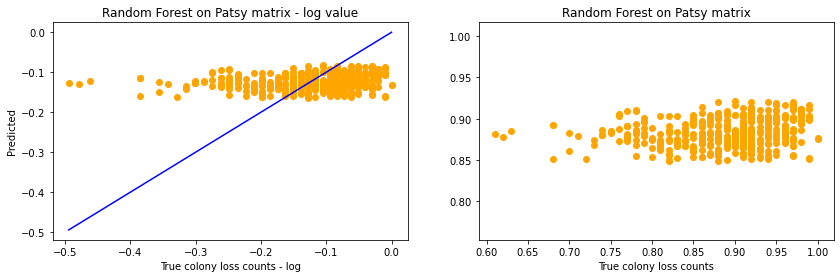

In [244]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, rf_test_pred_matrix, c="orange")

p1 = max(max(rf_test_pred_matrix), max(y_test))
p2 = min(min(rf_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Random Forest on Patsy matrix - log value")

ax2.scatter(np.exp(y_test), np.exp(rf_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Random Forest on Patsy matrix")
ax2.axis('equal')

plt.show()

## Support Vector regression

#### SV - create model object

In [245]:
sv_base_model = svm.SVR(kernel="poly", degree=3, epsilon=0.1, coef0=1)

#### SV - create params object

In [246]:
sv_params = {'model__C': [0.1, 1, 10, 100, 1000], 
             'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto']}

#### SV - create pipeline

In [247]:
sv_pipeline = pipeline.Pipeline(steps=[("model", sv_base_model)])

#### SV - create baseline grid

In [248]:
sv_baseline_grid = model_selection.GridSearchCV(
                        estimator=sv_pipeline,
                        param_grid=sv_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        cv=cross_validator,
                        verbose=1
                    )

### Support Vector: naive model

#### SV: naive - fit model

In [249]:
start = time.time()
sv_base_mod = sv_baseline_grid.fit(X_train_null, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 1.10 seconds


#### SV: naive - CV score distribution

Elapsed time: 0.04 seconds


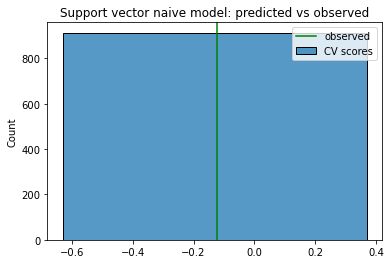

In [250]:
sv_base_best_estimator = sv_base_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores = model_selection.cross_val_score(
                    sv_base_best_estimator,
                    X_train_null,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

sv_naive_train_pred = sv_base_best_estimator.predict(X_train_null)
sns.histplot(sv_naive_train_pred, label='CV scores').set(title='Support vector naive model: predicted vs observed')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()
plt.show()

#### SV: naive - train / test comparison

In [251]:
sv_naive_test_pred = sv_base_best_estimator.predict(X_test_null)

print(f"Mean train CV score: {np.mean(sv_cv_scores): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=sv_naive_test_pred): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=sv_naive_test_pred): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=sv_naive_test_pred, squared=False): .3f}")

Mean train CV score: -0.070
Test MAE:  0.057
Test R-squared: -0.007
Test RMSE:  0.083


### Support Vector: with features

#### SV: with features - fit model - predictor: regions

In [252]:
start = time.time()
sv_regions_mod = sv_baseline_grid.fit(X_train_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 1.18 seconds


#### SV: with features - CV score distribution - predictor: regions

Elapsed time: 0.05 seconds


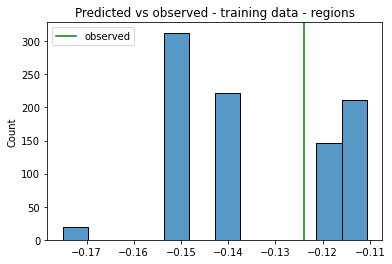

In [253]:
sv_regions_best_estimator = sv_regions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_regions = model_selection.cross_val_score(
                    sv_regions_best_estimator,
                    X_train_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_regions_sv = sv_regions_best_estimator.predict(X_train_regions)
sns.histplot(train_pred_regions_sv).set(title='Predicted vs observed - training data - regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: regions

In [254]:
test_pred_sv_regions = sv_regions_best_estimator.predict(X_test_regions)

print(f"Mean train CV score: {np.mean(sv_cv_scores_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_regions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_regions, squared=False): .3f}")

Mean train CV score: -0.070
Test MAE:  0.057
Test R-squared:  0.012
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: regions

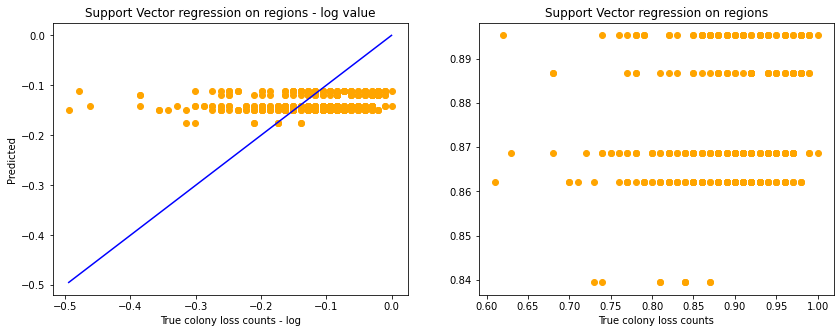

In [255]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_regions, c="orange")

p1 = max(max(test_pred_sv_regions), max(y_test))
p2 = min(min(test_pred_sv_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on regions - log value")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on regions")

plt.show()

#### SV: with features - fit model - predictor: subregions

In [256]:
start = time.time()
sv_subregions_mod = sv_baseline_grid.fit(X_train_subregions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 1.35 seconds


#### SV: with features - CV score distribution - predictor: subregions

Elapsed time: 0.06 seconds


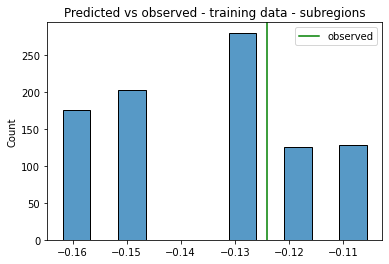

In [257]:
sv_subregions_best_estimator = sv_subregions_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_subregions = model_selection.cross_val_score(
                    sv_subregions_best_estimator,
                    X_train_subregions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_subregions_sv = sv_subregions_best_estimator.predict(X_train_subregions)
sns.histplot(train_pred_subregions_sv).set(title='Predicted vs observed - training data - subregions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: subregions

In [258]:
test_pred_sv_subregions = sv_subregions_best_estimator.predict(X_test_subregions)

print(f"Mean train CV score: {np.mean(sv_cv_scores_subregions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_subregions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_subregions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_subregions, squared=False): .3f}")

Mean train CV score: -0.070
Test MAE:  0.058
Test R-squared:  0.039
Test RMSE:  0.081


#### SV: with features - plotting observed vs predicted - predictor: subregions

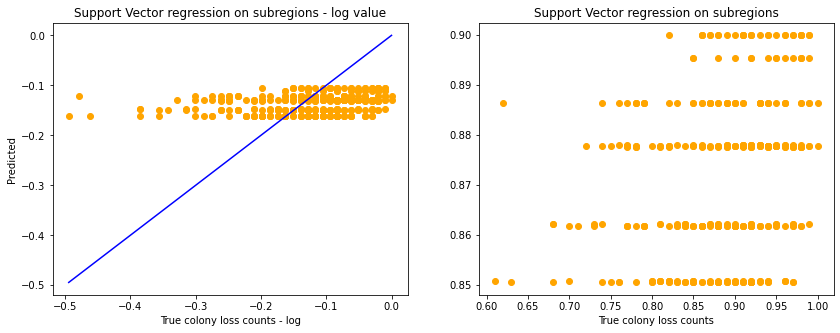

In [259]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_subregions, c="orange")

p1 = max(max(test_pred_sv_subregions), max(y_test))
p2 = min(min(test_pred_sv_subregions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on subregions - log value")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_subregions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on subregions")

plt.show()

#### SV: with features - fit model - predictor: all pests

In [260]:
start = time.time()
sv_all_pests_mod = sv_baseline_grid.fit(X_train_all_pests, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 14.94 seconds


#### SV: with features - CV score distribution - predictor: all pests

Elapsed time: 0.15 seconds


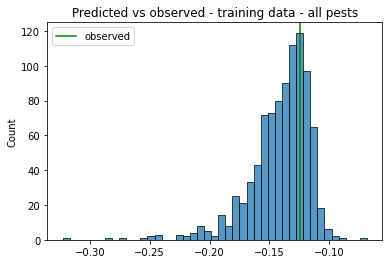

In [261]:
sv_all_pests_best_estimator = sv_all_pests_mod.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_all_pests = model_selection.cross_val_score(
                    sv_all_pests_best_estimator,
                    X_train_all_pests,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_all_pests_sv = sv_all_pests_best_estimator.predict(X_train_all_pests)
sns.histplot(train_pred_all_pests_sv).set(title='Predicted vs observed - training data - all pests')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: all pests

In [262]:
test_pred_sv_all_pests = sv_all_pests_best_estimator.predict(X_test_all_pests)

print(f"Mean train CV score: {np.mean(sv_cv_scores_all_pests): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_all_pests): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_all_pests): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_all_pests, squared=False): .3f}")

Mean train CV score: -0.068
Test MAE:  0.058
Test R-squared:  0.056
Test RMSE:  0.081


#### SV: with features - plotting observed vs predicted - predictor: all pests

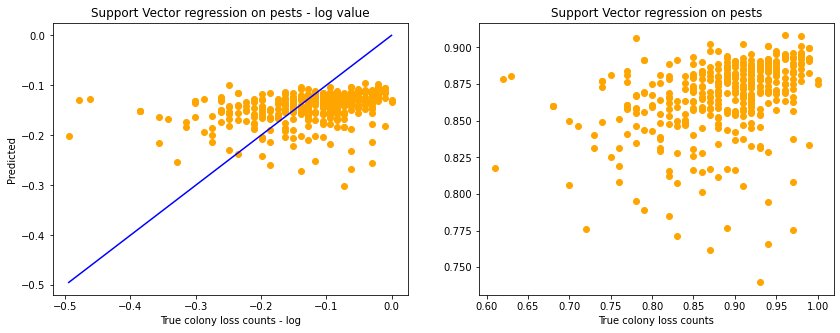

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, test_pred_sv_all_pests, c="orange")

p1 = max(max(test_pred_sv_all_pests), max(y_test))
p2 = min(min(test_pred_sv_all_pests), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector regression on pests - log value")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_all_pests), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector regression on pests")

plt.show()

#### SV: with features - fit model - predictor: mites and regions

In [264]:
start = time.time()
sv_mites_regions = sv_baseline_grid.fit(X_train_mites_regions, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 6.35 seconds


#### SV: with features - CV score distribution - predictor: mites and regions

Elapsed time: 0.07 seconds


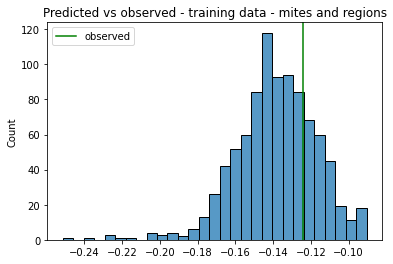

In [265]:
sv_mites_regions_best_estimator = sv_mites_regions.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_mites_regions = model_selection.cross_val_score(
                    sv_mites_regions_best_estimator,
                    X_train_mites_regions,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

train_pred_sv_mites_regions = sv_mites_regions_best_estimator.predict(X_train_mites_regions)
sns.histplot(train_pred_sv_mites_regions).set(title='Predicted vs observed - training data - mites and regions')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: mites and regions

In [266]:
test_pred_sv_mites_regions = sv_mites_regions_best_estimator.predict(X_test_mites_regions)

print(f"Mean train CV score: {np.mean(test_pred_sv_mites_regions): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=test_pred_sv_mites_regions): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=test_pred_sv_mites_regions): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=test_pred_sv_mites_regions, squared=False): .3f}")

Mean train CV score: -0.139
Test MAE:  0.059
Test R-squared:  0.008
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: mites and regions

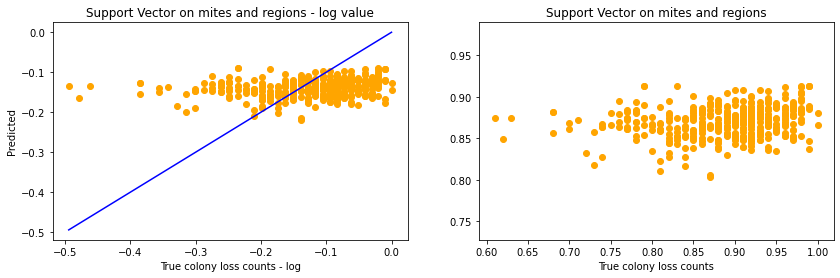

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, test_pred_sv_mites_regions, c="orange")

p1 = max(max(test_pred_sv_mites_regions), max(y_test))
p2 = min(min(test_pred_sv_mites_regions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector on mites and regions - log value")

ax2.scatter(np.exp(y_test), np.exp(test_pred_sv_mites_regions), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector on mites and regions")
ax2.axis('equal')

plt.show()

#### SV: with features - fit model - predictor: Patsy matrix

In [268]:
start = time.time()
sv_matrix_train = sv_baseline_grid.fit(train_model_matrix, y_train)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Elapsed time: 18.73 seconds


#### SV: with features - CV score distribution - predictor: Patsy matrix

Elapsed time: 0.04 seconds


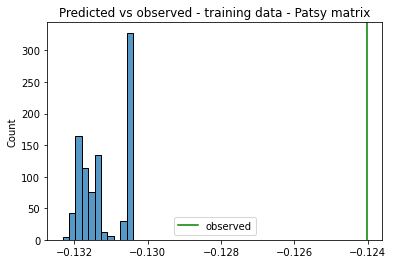

In [269]:
sv_matrix_best_estimator = sv_matrix_train.best_estimator_

# Distribution of cross-val score
start = time.time()
sv_cv_scores_matrix = model_selection.cross_val_score(
                    sv_matrix_best_estimator,
                    train_model_matrix,
                    y_train,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                )
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

sv_train_pred_matrix = sv_matrix_best_estimator.predict(train_model_matrix)
sns.histplot(sv_train_pred_matrix).set(title='Predicted vs observed - training data - Patsy matrix')
plt.axvline(x=np.mean(y_train), ymin=0, ymax=12, label='observed', color='green')
plt.legend()

#### SV: with features - metrics - predictor: Patsy matrix

In [270]:
sv_test_pred_matrix = sv_matrix_best_estimator.predict(test_model_matrix)

print(f"Mean train CV score: {np.mean(sv_cv_scores_matrix): .3f}")
print(f"Test MAE: {metrics.median_absolute_error(y_true=y_test, y_pred=sv_test_pred_matrix): .3f}")
print(f"Test R-squared: {metrics.r2_score(y_true=y_test, y_pred=sv_test_pred_matrix): .3f}")
print(f"Test RMSE: {metrics.mean_squared_error(y_true=y_test, y_pred=sv_test_pred_matrix, squared=False): .3f}")

Mean train CV score: -0.070
Test MAE:  0.057
Test R-squared: -0.007
Test RMSE:  0.083


#### SV: with features - plotting observed vs predicted - predictor: Patsy matrix

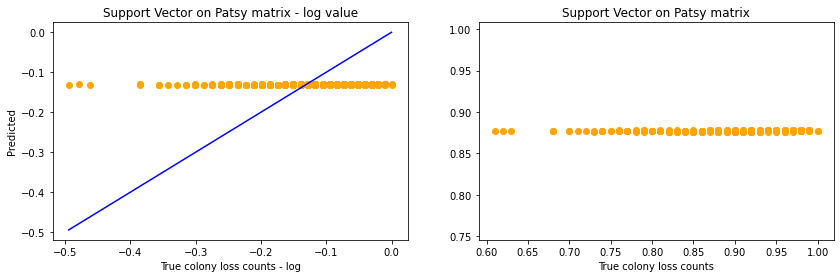

In [271]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.scatter(y_test, sv_test_pred_matrix, c="orange")

p1 = max(max(sv_test_pred_matrix), max(y_test))
p2 = min(min(sv_test_pred_matrix), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.set(xlabel='True colony loss counts - log', ylabel='Predicted', title="Support Vector on Patsy matrix - log value")

ax2.scatter(np.exp(y_test), np.exp(sv_test_pred_matrix), c="orange")
ax2.set(xlabel='True colony loss counts', title="Support Vector on Patsy matrix")
ax2.axis('equal')

plt.show()